<a href="https://colab.research.google.com/github/RichardHarwood/3D-Cell-Workflow/blob/main/Analysis_Examples_Incorparating_3D_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wget
!pip install open3d
!pip install vedo
#!pip install stackview ipycanvas==0.11
import os
!git clone https://github.com/wolny/pytorch-3dunet.git
%cd pytorch-3dunet
!python setup.py install
!pip install imagecodecs
!pip install skan
!pip install porespy
!pip install pypardiso
!pip install plotly

fatal: destination path 'pytorch-3dunet' already exists and is not an empty directory.
/content/pytorch-3dunet
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_instal

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#need to set appropriate  home folder
import os.path
from os import path
if path.exists('/content/drive/MyDrive/3D_UNET_analysis_eg/') == False:
  os.mkdir('/content/drive/MyDrive/3D_UNET_analysis_eg/')
home_folder = "/content/drive/MyDrive/3D_UNET_analysis_eg/"

In [5]:
#Create Config Folder
if path.exists(home_folder+'config_files') == False:
  os.mkdir(home_folder+'config_files')
config_folder = home_folder+'config_files/'

In [6]:
#Create Checkpoint Folder
if path.exists(home_folder+'checkpoint_dir') == False:
  os.mkdir(home_folder+'checkpoint_dir')
checkpoint_dir = home_folder+'checkpoint_dir/'

In [7]:
#Create Folder to store images we want to segment
if path.exists(home_folder+'segment_this_folder') == False:
  os.mkdir(home_folder+'segment_this_folder')
imgs_to_seg_dir = home_folder+'segment_this_folder/'

## Download image to test workflow on
can be slow depending on image, using a very small one here to illustrate the workflow

In [8]:
import wget
import wget
if os.path.isfile(imgs_to_seg_dir+'sml_corn_eg.tif'):
  print("image already download")
else:
  wget.download("https://zenodo.org/records/13943098/files/"+"recon_sub__095_corn_pvc_4days_R1_wb_1x_stitch.tif_031.tif"+"?download=1", out=imgs_to_seg_dir+'sml_corn_eg.tif')



image already download


In [9]:
#!pip install tiffile

In [10]:
#Convert to H5
import skimage
import imagecodecs
import h5py
img=skimage.io.imread(imgs_to_seg_dir+'sml_corn_eg.tif')
hf = h5py.File(imgs_to_seg_dir+"sml_corn_eg.h5", 'w')
hf.create_dataset('raw', data=img)
hf.close()



#Downlaod model to segment image


In [11]:
if os.path.isfile(checkpoint_dir+'3D_Unet_Root_Model.pytorch'):
  print("model already download")
else:
  wget.download("https://zenodo.org/records/13958667/files/"+"3D_Unet_Root_Model.pytorch"+"?download=1", out=checkpoint_dir+'3D_Unet_Root_Model.pytorch')


model already download


In [12]:
model_name = "UNet3D"
in_channels = 1
out_channels= 1
layer_order = "gcr"
f_maps = [32,
          64,
          128,
          256]
num_groups = 8
final_sigmoid = True
is_segmentation = True
batch_size= 2  #important for gpu memory
num_workers= 2
raw_internal_path= "raw"
label_internal_path= "label"
weight_internal_path= None
######################
slice_builder_name= "SliceBuilder"
slice_builder_name_predict = "SliceBuilder"
patch_shape= [40, 170, 170]  #Change depending on GPU memory
stride_shape= [20, 40, 40]   #Change depending on GPU memory
halo_shape= [16, 32, 32]
threshold = 0.01
slack_acceptance = 0.01
name_transformer= "Standardize"
name_transformer_label= "BlobsToMask"
append_label= False
boundary= False
ToTensor_name = "ToTensor"
expand_dims_false= False
expand_dims_true= True
#####################
predictor_name='StandardPredictor'
#################################
file_paths_test= imgs_to_seg_dir
#############################
model_path=checkpoint_dir+'3D_Unet_Root_Model.pytorch'

In [13]:
import yaml
test_config_yaml ={
    "model_path": model_path,
    "model": {
        "name": model_name,
        "in_channels": in_channels,
        "out_channels": out_channels,
        "layer_order": layer_order,
        "f_maps": f_maps,
        "num_groups": num_groups,
        "final_sigmoid": final_sigmoid,
        "is_segmentation": is_segmentation
    },
    "predictor": {
        "name": predictor_name
    },
    "loaders": {
        "batch_size": batch_size,
        "raw_internal_path": raw_internal_path,
        "num_workers": num_workers,
        "test": {
            "file_paths": [
                file_paths_test
            ],
            "slice_builder": {
                "name": slice_builder_name_predict,
                "patch_shape": patch_shape,
                "stride_shape": patch_shape,
                "halo_shape": halo_shape
            },
            "transformer": {
                "raw": [
                    {
                        "name": name_transformer
                    },
                    {
                        "name": ToTensor_name,
                        "expand_dims": expand_dims_true
                    }
                ]
            }
        }
    }
}

with open(config_folder+'predict.yaml', 'w') as yaml_file:
    yaml.dump(test_config_yaml, yaml_file, default_flow_style=False, sort_keys=False)


In [14]:
!predict3dunet --config /content/drive/MyDrive/3D_UNET_analysis_eg/config_files/predict.yaml

2024-11-19 05:04:19,907 [MainThread] INFO UNet3DPredict - Loading model from /content/drive/MyDrive/3D_UNET_analysis_eg/checkpoint_dir/3D_Unet_Root_Model.pytorch...
/usr/local/lib/python3.10/dist-packages/pytorch3dunet-1.8.7-py3.10.egg/pytorch3dunet/unet3d/utils.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use ca

In [15]:
import glob
import numpy as np
raw_data_path= file_paths_test
raw_file_names = [os.path.basename(x) for x in glob.glob(imgs_to_seg_dir+"*.h5")]
raw_file_names = [e for e in raw_file_names if "predictions" in e ]
#################################
if path.exists(home_folder+'processed/') == False:
  os.mkdir(home_folder+'processed/')
file_paths_processed= home_folder+'processed/'
#########################
#raw_file_names

UNIQUE_ID =np.unique(raw_file_names)
len(UNIQUE_ID)

1

In [16]:
UNIQUE_ID

array(['sml_corn_eg_predictions.h5'], dtype='<U26')

In [17]:
scale_factor=0.5
Z=6.5*2
Y=6.5*2
X=6.5*2

sml_corn_eg_predictions.h5


<ipython-input-18-8c8c0644d669>:32: UserWarning: /content/drive/MyDrive/3D_UNET_analysis_eg/processed/sml_corn_eg_predictions.h5_processed.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  skimage.io.imsave(file_paths_processed+i+"_processed.tif", root_binary_clean, check_contrast=False)


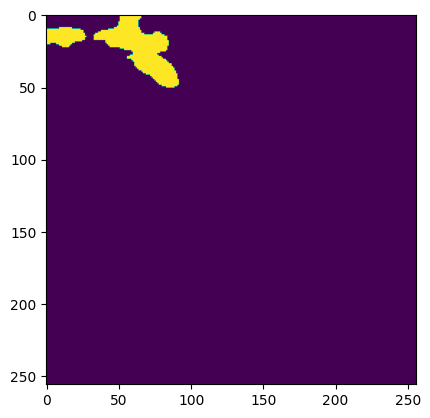

In [18]:
import h5py
import cv2
import skimage
from skimage.filters import threshold_otsu, threshold_yen,threshold_li
from skimage.measure import label
from skimage.morphology import remove_small_objects
from vedo import *
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

for i in UNIQUE_ID:
    print(i)
    hf=h5py.File(raw_data_path+i)
    hf.keys()
    dataset_IMGs= hf['predictions']
    unet_prediction=dataset_IMGs[:]
    unet_prediction=unet_prediction[0,:,:,:]
    unet_prediction=zoom(unet_prediction, (scale_factor,scale_factor, scale_factor), order=1)
    unet_prediction = cv2.normalize(unet_prediction, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    thresh = threshold_li(unet_prediction)
    root_binary = unet_prediction > thresh

    root_binary_clean=label(root_binary)
    min_size_coef=1200
    root_binary_clean = remove_small_objects(root_binary_clean, min_size=min_size_coef, connectivity=2)
    root_binary_clean = (root_binary_clean != 0).astype(bool)


    root_VOL = Volume(root_binary_clean, spacing=((1),(1),(1)))
    root_ISO = root_VOL.isosurface(1)
    root_ISO.write(file_paths_processed+i+"__root.stl")
    skimage.io.imsave(file_paths_processed+i+"_processed.tif", root_binary_clean, check_contrast=False)
    plt.imshow(root_binary_clean[30])

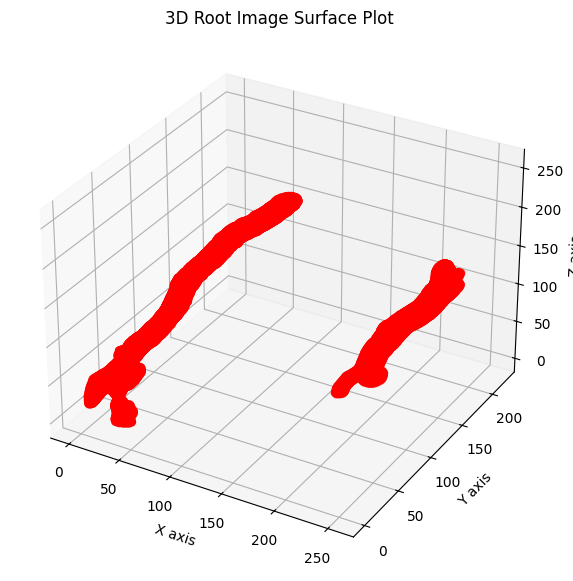

In [19]:
#Stls love crashing colab for some reason (PyVitsa and Vedo) so just surface plot the root to inspect
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
binary_image=root_binary_clean.astype(int)
x, y, z = np.indices(binary_image.shape)
x_vals, y_vals, z_vals = x[binary_image == 1], y[binary_image == 1], z[binary_image == 1]
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_vals, y_vals, z_vals, c='r', marker='o')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Root Image Surface Plot')
plt.show()

#Example one: Extract the skeleton
https://skeleton-analysis.org/stable/index.html

In [20]:
#package import not sorted correctly, kind of done for each example
import numpy as np
import skan
from skimage.data import binary_blobs
from skimage.morphology import skeletonize
import scipy.ndimage as ndi

#root_binary_clean_sml=zoom(root_binary_clean, (0.5,0.5, 0.5), order=0)
binary_skeleton = skeletonize(root_binary_clean)
skeleton = skan.Skeleton(binary_skeleton)

all_paths = [
        skeleton.path_coordinates(i)
        for i in range(skeleton.n_paths)
        ]

paths_table = skan.summarize(skeleton, separator='_')
paths_table['path_id'] = np.arange(skeleton.n_paths)
paths_table['random_path_id'] = np.random.default_rng().permutation(skeleton.n_paths)*6.6 #need to tweak this for vis to work
paths_table.head()


,skeleton_id,node_id_src,node_id_dst,branch_distance,branch_type,mean_pixel_value,stdev_pixel_value,image_coord_src_0,image_coord_src_1,image_coord_src_2,...,image_coord_dst_2,coord_src_0,coord_src_1,coord_src_2,coord_dst_0,coord_dst_1,coord_dst_2,euclidean_distance,path_id,random_path_id
0,0,0,45,43.040902,1,1.0,0.0,3,18,27,...,54,3,18,27,26,21,54,35.594943,0,52.8
1,0,45,111,62.212474,1,1.0,0.0,26,21,54,...,4,26,21,54,31,15,4,50.606324,1,59.4
2,0,45,78,7.610366,2,1.0,0.0,26,21,54,...,59,26,21,54,28,20,59,5.477226,2,19.8
3,0,78,317,276.638391,1,1.0,0.0,28,20,59,...,250,28,20,59,131,101,250,231.626855,3,46.2
4,0,78,92,1.414214,2,1.0,0.0,28,20,59,...,60,28,20,59,29,20,60,1.414214,4,0.0


#Example two: Extract the pore network

Initial number of peaks:  737
Peaks after trimming saddle points:  522
Peaks after trimming nearby peaks:  490


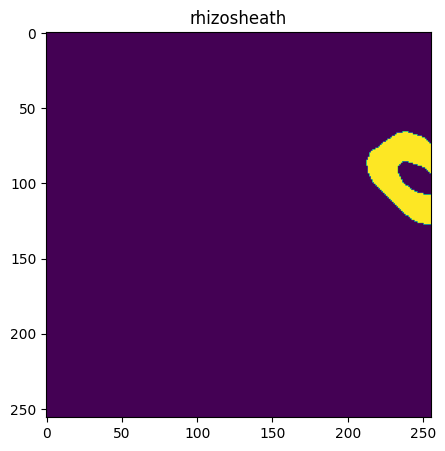

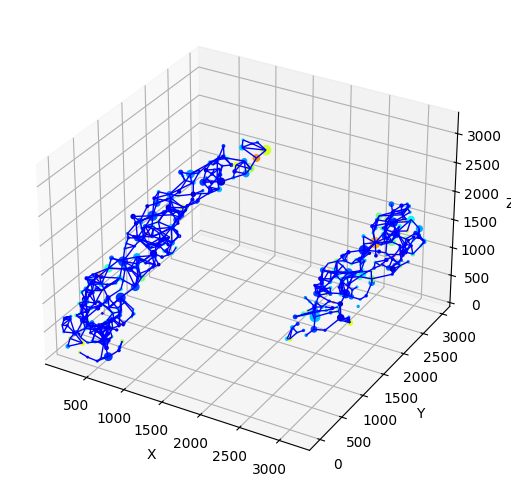

In [21]:
import porespy as ps
import openpnm as op
import scipy.ndimage as spim
from porespy.filters import find_peaks, trim_saddle_points, trim_nearby_peaks
from porespy.tools import randomize_colors
from scipy import ndimage as ndi
from skimage.segmentation import watershed
import seaborn as sns
#Dilate around the root to make a rhizosheath
diamond = ndi.generate_binary_structure(rank=3, connectivity=1)
iternation_n=20
dilated = ndi.binary_dilation(root_binary_clean, diamond, iterations=iternation_n)
rhizosheath= root_binary_clean ^ dilated
#Get Pore Network
ct_data=zoom(img, (scale_factor,scale_factor, scale_factor), order=1)
pore_thresh = threshold_otsu(ct_data)
pore= ct_data < pore_thresh
#Get Pore Network in Rhizosheath
pore_rhizo=pore * rhizosheath

#######################################
sigma = 0.4
dt = spim.distance_transform_edt(input=pore_rhizo)
dt1 = spim.gaussian_filter(input=dt, sigma=sigma)
peaks = find_peaks(dt=dt)
print('Initial number of peaks: ', spim.label(peaks)[1])
peaks = trim_saddle_points(peaks=peaks, dt=dt1)
print('Peaks after trimming saddle points: ', spim.label(peaks)[1])
peaks = trim_nearby_peaks(peaks=peaks, dt=dt)
peaks, N = spim.label(peaks)
print('Peaks after trimming nearby peaks: ', N)
regions = watershed(image=-dt, markers=peaks, mask=dt > 0)
regions = randomize_colors(regions)
############################
mat_slice=int(len(rhizosheath)/2)
plt.figure(figsize= (5,5));
plt.imshow(rhizosheath[mat_slice]);
plt.title("rhizosheath");
plt.show();

import pandas as pd
import imageio
net = ps.networks.regions_to_network(regions*pore_rhizo, voxel_size=X)
pn = op.io.network_from_porespy(net)

pore_region_volume_df=pd.DataFrame(pn['pore.region_volume'])
throat_cons_df=pd.DataFrame(pn['throat.conns'])

#saves data for visualising, cant be donw in colab, check our parraview
#pore_rhizo = (np.swapaxes(pore_rhizo, 2, 0)) # This isjust some of ps.tools.align_image_with_openpnm(im), it works to align image with
imageio.volsave(file_paths_processed+'pore_networkfor_rhizosheath.tif', np.array(pore_rhizo, dtype=np.int8))
op.io.project_to_vtk(project=pn.project,filename=(file_paths_processed+"pore_network"))

#sns.kdeplot(data=pore_region_volume_df, x=0).set_title("Spead of region pore size");

fig, ax = plt.subplots(figsize=[5, 5])
#ax.imshow(slice_2d.T, cmap=plt.cm.bone);
op.visualization.plot_coordinates(ax=fig,
                                  network=pn,
                                  size_by=pn["pore.region_volume"],
                                  color_by=pn["throat.total_length"],
                                  markersize=50)
op.visualization.plot_connections(network=pn, ax=fig)
ax.set_title('Pore Network in the rhizosheath')
plt.show()



In [22]:
#interact with the pore network
op.visualization.plot_notebook(network=pn, node_color=0, edge_color=0, node_size=1, node_scale=20, edge_scale=5, colormap='viridis')

#Example three: Visualize  root density
Pretty underwhelming with this example